In [ ]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
from glob import glob
import subprocess as s
warnings.filterwarnings("ignore")

from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
from scipy.optimize import curve_fit
from copy import deepcopy
import datetime
import pandas as pd

from astropy.io import fits
from scipy.optimize import curve_fit
# from astropy.visualization import astropy_mpl_style
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# plt.style.use(astropy_mpl_style)
plt.style.use('default')
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
import numpy as np
kernel = Gaussian2DKernel(x_stddev=1)

fit gaussian to lc

In [ ]:
def plotting(x, y, y_err, model, xlim, ObsID, instrument, figures_path,  xscale='linear', bkg=False):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    ax1.tick_params(direction='in', which='both', length=5, labelsize=15)
    ax2.tick_params(direction='in', which='both', length=5, labelsize=15)

    plt.suptitle(instrument)
    
    ax1.set_ylabel(r'N', fontsize = 15.0)
    ax1.set_xscale(xscale)
    
    ax1.set_xlim(0, xlim[1])

    ax1.errorbar(x, y, yerr=y_err, fmt='o', capsize=2, label='Data')
    ax1.plot(x, model, label='Fit')
    ax1.legend(loc='best', fontsize=15.0)

    ax2.set_ylabel(r'Ratio', fontsize = 15.0)
    ax2.set_ylim(0.5,1.5)
    ax2.axhline(y=1.)

    ax2.errorbar(x, y/model, yerr=y_err/model, fmt='o', capsize=2)

    ax2.set_xlabel('Rate [cts/s]', fontsize = 15.0)

    plt.subplots_adjust(hspace=0.1)
    
    plt.show()
def input_lc(fname, path, PN_cts_limit, EMOS_cts_limit):
    os.chdir(path)
    hdul = fits.open(fname)
    data = hdul[1].data
    time = data['time']
    rate = data['rate']
    rate_err = data['error']
    hdul.close()
    # Delete zero rates
    where = np.where(rate == 0)[0]
    time = np.delete(time, where)
    rate = np.delete(rate, where)
    rate_err = np.delete(rate_err, where)
    # filter maximum counts rate before fitting
    if('EPN' in fname or 'Oot' in fname):
        where = np.where(rate > PN_cts_limit)[0]
        time = np.delete(time, where)
        rate = np.delete(rate, where)
        rate_err = np.delete(rate_err, where)
            
    else:
        where = np.where(rate > EMOS_cts_limit)[0]
        time = np.delete(time, where)
        rate = np.delete(rate, where)
        rate_err = np.delete(rate_err, where)
    return rate, time, rate_err, data['rate'], data['time']
def hist_filter(rate):
    # Make histogram
    hist, bin_edges = np.histogram(np.log10(rate), bins=120)
        
    bin_mid = 0.5*(bin_edges[1:] + bin_edges[:-1])
    bin_mid = 10**(bin_mid)
    hist_err = np.sqrt(hist)
    where = np.where(hist_err == 0)[0]
    bin_mid = np.delete(bin_mid, where)
    hist = np.delete(hist, where)
    hist_err = np.delete(hist_err, where)
    return hist, bin_mid, hist_err
def fit_gauss(hist, bin_mid, hist_err):
    # Define gaussian function
    gaussian = lambda x, amp, cen, sig: amp * np.exp(-(x-cen)**2 / sig**2)
    # Fit
    init_vals = [max(hist), np.mean(bin_mid), 0.4]
    best_vals, covar = curve_fit(gaussian, bin_mid, hist, p0=init_vals, sigma=1/hist_err, bounds=((0, 0, 0),
                                                                                        (np.inf, np.inf, np.inf)),
                                maxfev=100000)
    return best_vals[0], best_vals[1], best_vals[2]
def fit_dirty(iter_cts, fname, path, scale, PN_cts_limit=1.5, EMOS_cts_limit=1.5, PLOT=True):
    rate, time, rate_err, rate_ori, time_ori = input_lc(fname, path, PN_cts_limit, EMOS_cts_limit)
    hist, bin_mid, hist_err = hist_filter(rate)
    amp, mu,sigma = fit_gauss(hist, bin_mid, hist_err)
    newrate = deepcopy(rate)
    newtime = deepcopy(time)
    print(newrate.max(), len(newtime))
    for i in range(iter_cts):
        where = (newrate<mu+scale*sigma)&(newrate>mu-scale*sigma)
        newrate = newrate[where]
        newtime = newtime[where]
        hist, bin_mid, hist_err = hist_filter(newrate)
        amp, mu,sigma = fit_gauss(hist, bin_mid, hist_err)
        print(newrate.max(), len(newtime), amp, mu, sigma)
    if PLOT==True:
        gaussian = lambda x, amp, cen, sig: amp * np.exp(-(x-cen)**2 / sig**2)
        plotting(bin_mid, hist, hist_err, gaussian(bin_mid, amp, mu, sigma), 
                    [mu-scale*sigma, mu+scale*sigma], fname, 
                    fname, figures_path='./', bkg=True)
        # check with the original lightcurve data
        plt.figure(figsize = (8,8))
        plt.scatter(newtime,newrate, alpha=0.5, s=2, color = 'b')#, yerr=dat['ERROR'])
        plt.scatter(time_ori,rate_ori, alpha=0.5, s=1, color = 'k')#, yerr=dat['ERROR'])
        plt.axhline(mu+scale*sigma, color = 'r')
        plt.axhline(mu-scale*sigma, color = 'r')
        plt.title(f'{fname}')
        plt.savefig(f'{fname}.png')
    return mu,sigma

imshow the data 

In [ ]:
from astropy.visualization import astropy_mpl_style
import matplotlib.colors as colors
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)

'''
evselect table=mos1_closed_FF_2022_v2_obs201.fits.gz xcolumn=X ycolumn=Y \
imagebinning=binSize ximagebinsize=20 yimagebinsize=20 withimageset=true \
imageset=mos1_closed_FF_2022_v2_obs201.img
'''

image_file = get_pkg_data_filename('mos1_closed_FF_2022_v2_obs201.img')
image_data = fits.getdata(image_file, ext=0)
plt.figure(figsize = (8,8))
plt.imshow(image_data, cmap='binary', norm = colors.LogNorm(vmin = 0.1, vmax = 100))
plt.colorbar()
plt.show()
plt.clf()

# 0. prereduction data

In [ ]:
'''
cd reduction_230227/101
export SAS_CCF=/stage/headat/yanling/xmm/0502020101/ccf.cif
export SAS_ODF=/stage/headat/yanling/xmm/0502020101/1378_0502020101_SCX00000SUM.SAS
emproc
mkdir Main
cd Main
epproc

cd ..
mkdir Oot
cd Oot
epproc withoutoftime=yes

'''
'''
cd 201
export SAS_CCF=/stage/headat/yanling/xmm/0502020201/ccf.cif
export SAS_ODF=/stage/headat/yanling/xmm/0502020201/1380_0502020201_SCX00000SUM.SAS
emproc
cd Main
epproc
cd ..
cd Oot
epproc withoutoftime=yes
'''
import glob
data_dir = '/stage/headat/yanling/xmm/reduction_230227/101'
os.chdir(data_dir)
pn_path = f'{data_dir}/Main'
Oot_path = f'{data_dir}/Oot'

# os.system(f'cp {pn_path}/*_ImagingEvts*.ds .')
# os.system(f'cp {Oot_path}/*_ImagingEvts*.ds 1378_0502020201_Oot_S003_ImagingEvts.ds')


# 1. Extract lc

In [ ]:
'''
We are doing twice cleaning
1. 10-12 keV for mos, 10-14 keV for PN
2. 0.4-1 keV for mos and pn

'''
f = open(f'{data_dir}/data_lc.sh', 'w')
instruments=['EMOS1', 'EMOS2', 'EPN', 'Oot']
energy_bands_1 = [(10, 12), (10,12), (10,14), (10,14)]
energy_bands_2 = [(0.4, 1), (0.4, 1), (0.4, 1), (0.4, 1)]
# energy_bands_2 = [(4, 10), (4, 10), (4, 10), (4, 10)]
for energy_bands in [energy_bands_2]:
    for i, instrument in enumerate(instruments):
        if(instrument == 'EPN') or (instrument =='Oot'):
            ins = 'EP'
            pattern = 4
        else:
            ins = 'EM'
            pattern = 12

        fname = glob.glob(f'*{instrument}*_ImagingEvts.ds')[0]

        print(f'evselect table={fname} withrateset=Y rateset=rate_{int(1000*energy_bands[i][0])}-{int(1000*energy_bands[i][1])}_{instrument}.fits \
maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression="#XMMEA_{ins} && (PI in [{int(1000*energy_bands[i][0])}:{int(1000*energy_bands[i][1])}]) && (PATTERN<={pattern})"')
        f.write(f'evselect table={fname} withrateset=Y rateset=rate_{int(1000*energy_bands[i][0])}-{int(1000*energy_bands[i][1])}_{instrument}.fits \
maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression="#XMMEA_{ins} && (PI in [{int(1000*energy_bands[i][0])}:{int(1000*energy_bands[i][1])}]) && (PATTERN<={pattern})"\n')
f.close()

plot lightcone

In [ ]:
files = ['rate_Oot']

for file in files:
    hdul = fits.open(f'{file}.fits')
    dat = hdul[1].data
    hdul.close()
    plt.figure(figsize = (8,8))
    plt.scatter(dat['TIME'],dat['RATE'])#, yerr=dat['ERROR'])
    # plt.axhline(1.264, color = 'r')
    plt.axhline(0.35, color = 'r')
    plt.title(f'{file}')
    plt.show()

In [ ]:
# show gti
# os.chdir(tmp_dir)
from astropy.io import fits

os.chdir(f'{data_dir}')
hdul = fits.open('EMOS2_gti.fits')
hdul.info()
hdul.close()

check total exp time

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
for obs in ['101']:
    fig = plt.subplots(figsize = (8,8))
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    os.chdir(data_dir)
    hdul = fits.open('EMOS1_gti_loband_2023-05-05.fits')
    dat1 = np.array(hdul[1].data)
    hdul.close()
    hdul = fits.open('EPN_gti_loband_2023-05-05.fits')
    dat2 = np.array(hdul[1].data)
    hdul.close()
    cb = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']

    for j,dat in enumerate([dat1, dat2]):
        for i in range(1,len(dat)):
            plt.hlines(j, dat['START'][i], dat['STOP'][i],color = cb[j], lw=4)
    plt.title(f'obs{obs}')
    plt.legend(loc = 'center right')
    plt.text(np.mean(dat['START']), 0.5, f"MOS1 sumtime: {np.sum(dat1['STOP']-dat1['START'])}")
    plt.text(np.mean(dat['START']), 0.4, f"MOS2 sumtime: {np.sum(dat2['STOP']-dat2['START'])}")


In [ ]:
plt.close()

fit lightcone with gaussian to determine the most stable ctr upper limit

In [ ]:
files = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
for file in files:
    fit(f'rate_{file}.fits', './', PN_cts_limit = 1.3, EMOS_cts_limit = 0.4,)

filter data based on gaussian fit and visual inspect

In [ ]:
# generate gti files after gaussian fitting the lightcurve
# generate the filtered events and images of [corner(_oofov)] and [all fov without corner region(_fov)]

from fit_gauss_to_lc import fit_lc_dirty, create_logfile
import datetime
import glob
# Create GTI and filter
instruments = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
energy_bands_1 = [(10, 12), (10,12), (10,14), (10,14)]
energy_bands_2 = [(0.4, 1), (0.4, 1), (0.4, 1), (0.4, 1)]
# energy_bands_2 = [(4, 10), (4, 10), (4, 10), (4, 10)]
scale = [2,2,2,2]
'''
first extract lightcurves at high energy band and low energy band, 
and fit the gaussian for two bands in parallel, and use these 2 gti to extract image from origin event file.

STEP0: extract lightcurves
Generate lightcurve of 10-12 keV, 0.4-1keV for EMOS1, EMOS2. 
Generate lightcurve of 10-14 keV, 0.4-1keV for EPN, Oot.
The time bin is 100s.
-> rate_10000-12000_EMOS*.fits, rate_10000-14000_EPN.fits, rate_10000-14000_Oot.fits, rate_400-1000_EMOS*.fits,

STEP1: clean at high energy range
For 10-12keV (10-14 keV) lightcurve for EMOS (EPN), fit gaussian iteratively until the parameters don't change. 
Visually inspect if the fitting curve and the data look like gaussian, if not, lower the ctr limit and refit.
Finally, for EMOS1 in obs101, limit ctr< 0.3 looks like gaussian. 
-> {inst}_gti_hiband.fits, {inst}_hiband_clean_fov.fits, rate_400-1000_{inst}_hiband_clean.fits

STEP2: clean at low energy range (0.4-1 keV)
-> {inst}_gti_loband.fits, {inst}_hiband_loband_clean_fov.fits

STEP3: calculate exptime after filtered
'''


# firstly filter the gti for high energy band (10-12keV for mos, 10-14keV for pn)

energy_names = ['hiband', 'loband']
os.chdir(f'/stage/headat/yanling/XMM_datareduction')
today = datetime.date.today()
for obs in ['101', '201']:
    os.system(f'rm log/{datetime.date.today()}/{obs}/*')
    print(obs)
    energy_bands = energy_bands_1
    j = 0
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    f1 = open(f'{data_dir}/data_gti_{energy_names[j]}_{datetime.date.today()}.sh', 'w')
    f2 = open(f'{data_dir}/data_clean_{energy_names[j]}_{datetime.date.today()}.sh', 'w')
    for i, instrument in enumerate(instruments):
        # define output_filenames
        gtifile = f'{instrument}_gti_{energy_names[j]}_{today}.fits'
        output_evtfile = f'{instrument}_{energy_names[j]}_clean_{today}'
        # create logger
        os.makedirs(f'log/{datetime.date.today()}/{obs}', exist_ok=True)
        logger = create_logfile('fit_lc_dirty', f'log/{datetime.date.today()}/{obs}/fit_lc_dirty.log')
        logger.info(f'filtering {fname}')
        figpath = f'/stage/headat/yanling/XMM_datareduction/fig/{datetime.date.today()}/{obs}'
        os.makedirs(figpath, exist_ok=True)
        
        # mos and pn have different hiband for filtering
        if(instrument == 'EPN') or (instrument =='Oot'):
            ins = 'EP'
            input_lc = f'rate_10000-14000_{instrument}.fits'
        else:
            ins = 'EM'
            input_lc = f'rate_10000-12000_{instrument}.fits'

        input_evtfile = glob.glob(f'{data_dir}/*{instrument}*_ImagingEvts.ds')[0]
        input_evtfile = input_evtfile.split('/')[-1]
        # fit the lightcurve with gaussian, determine filtering criteria
        amp, mean, sigma, hist, bin_mid = fit_lc_dirty(25, input_lc, data_dir, scale[i], 120, logger, figpath = figpath, EMOS_cts_limit=0.3, PLOT=False)
        max_cts = 2*sigma + mean
        # generate the gti: we use the rate_* lightcurve file to extract gti
        f1.write(f'tabgtigen table={input_lc} expression="RATE<={max_cts}" gtiset={gtifile}\n')  
        # generate the events of [corner(_oofov)] and [all fov without corner region(_fov)] by the above gti
        f2.write(f'evselect table={input_evtfile} withfilteredset=Y filteredset={output_evtfile}_oofov.fits destruct=Y keepfilteroutput=T expression="#XMMEA_16&&gti({gtifile},TIME)&&(PI>150)"\n') 
        f2.write(f'evselect table={input_evtfile} withfilteredset=Y filteredset={output_evtfile}_fov.fits destruct=Y keepfilteroutput=T expression="#XMMEA_{ins}&&gti({gtifile},TIME)&&(PI>150)"\n')
        # generate the corresponding images of previously generated events
        f2.write(f'evselect table={output_evtfile}_fov.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset={output_evtfile}_fov.img \n')
        f2.write(f'evselect table={output_evtfile}_oofov.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=20 yimagebinsize=20 withimageset=Y imageset={output_evtfile}_oofov.img \n')
    f2.close()
    f1.close()

    


In [ ]:
# NOTICE: RUN data_gti_hiband.sh  & data_clean_hiband.sh in 101 and 201 dir first then run the following
# then further filter the gti previously filtered gti for lower broad energy band (4-10 keV for mos and pn)
instruments = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
date = '2023-05-05'
for obs in ['101', '201']:
    energy_bands = energy_bands_2
    j = 1
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    scale = [2,2,2,2]
    f1 = open(f'{data_dir}/data_gti_{energy_names[j]}_{date}.sh', 'w')
    f2 = open(f'{data_dir}/data_clean_{energy_names[j]}_{date}.sh', 'w')

    for i, instrument in enumerate(instruments):
        # define output_filenames
        gtifile = f'{instrument}_gti_loband_{date}.fits'
        gtifile1 = f'{instrument}_gti_hiband_{date}.fits'
        output_evtfile = f'{instrument}_hiband_loband_clean_{date}'
        # create logger
        logger = create_logfile('fit_lc_dirty', f'log/{date}/{obs}/fit_lc_dirty_loband.log')
        logger.info(f'filtering {fname}')
        figpath = f'/stage/headat/yanling/XMM_datareduction/fig/{date}/{obs}'
        os.makedirs(figpath, exist_ok=True)

        if(instrument == 'EPN') or (instrument =='Oot'):
            ins = 'EP'
        else:
            ins = 'EM'

        # take the evtfile filtered by hiband just now
        input_evtfile = f'{instrument}_hiband_clean_{date}'
        # mos and pn have same loband
        input_lc = f'rate_400-1000_{instrument}.fits'
        # fit the lightcurve with gaussian, determine filtering criteria
        amp, mean, sigma, hist, bin_mid = fit_lc_dirty(25, input_lc, data_dir, scale[i], 120, logger, figpath = figpath, EMOS_cts_limit=0.6, PN_cts_limit=3, PLOT=False)
        max_cts = 2*sigma + mean
        # generate the gti
        f1.write(f'tabgtigen table={input_lc} expression="RATE<={max_cts}" gtiset={gtifile}\n')              
        # generate the events of [corner(_oofov)] and [all fov without corner region(_fov)]
        f2.write(f'evselect table={input_evtfile}_oofov.fits withfilteredset=Y filteredset={output_evtfile}_oofov.fits destruct=Y keepfilteroutput=T expression="gti({gtifile},TIME)&&gti({gtifile1},TIME)&&(PI>150)"\n')
        f2.write(f'evselect table={input_evtfile}_fov.fits withfilteredset=Y filteredset={output_evtfile}_fov.fits destruct=Y keepfilteroutput=T expression="#XMMEA_{ins}&&gti({gtifile},TIME)&&gti({gtifile1},TIME)&&(PI>150)"\n')
        # generate the corresponding images of previously generated events
        f2.write(f'evselect table={output_evtfile}_fov.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset={output_evtfile}_fov.img \n')
        f2.write(f'evselect table={output_evtfile}_oofov.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset={output_evtfile}_oofov.img \n')
        
    f2.close()
    f1.close()

In [ ]:
sh data_gti_hiband.sh
sh data_clean_hiband.sh
sh data_gti_loband.sh
sh data_clean_loband.sh

# 2. Extract image

In [ ]:
# MOS1 ccd6 loss after 2005.3.23
# https://www.cosmos.esa.int/web/xmm-newton/mos1-ccd6


import glob
import datetime

today = '2023-05-10'
for obs in ['101', '201']:
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    os.chdir(data_dir)
    # os.system(f'export SAS_CCF=/stage/headat/yanling/xmm/0502020{obs}/ccf.cif')
    # os.system(f'export SAS_ODF=/stage/headat/yanling/xmm/0502020{obs}/*SUM.SAS')
    f = open(f'data_img_allbands_{today}.sh', 'w')
    instruments = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
    for instrument in instruments:
        for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
            blo = band.split('-')[0]
            bhi = band.split('-')[1]
            if(instrument == 'EPN')or (instrument =='Oot'):
                ins = 'EP'
                pattern = 4
                
            else:
                ins = 'EM'
                pattern = 12
                
            # Create image
            input_evtfile = f'{instrument}_hiband_loband_clean_2023-05-05_fov.fits'
            input_attfile = glob.glob('*_AttHk.ds')[0]
            output_imgfile = f'{instrument}_counts_nr_{blo}-{bhi}_{today}.img'
            output_expmap = f'{instrument}_exp_nr_{blo}-{bhi}_{today}.img'
            if instrument=='EMOS1':
                f.write(f'evselect table={input_evtfile} xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={output_imgfile} \
expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI in [{blo}:{bhi}])&&(CCDNR.ne.6)&&FLAG==0"\n')
            else:
                f.write(f'evselect table={input_evtfile} xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={output_imgfile} \
expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI in [{blo}:{bhi}])&&FLAG==0"\n')
            # Create exposure map 
            f.write(f'eexpmap imageset={output_imgfile} attitudeset={input_attfile} eventset={input_evtfile} \
expimageset= pimin={blo} pimax={bhi}\n')
            # note: no expmap for oot
    f.close()
    # os.system(f'sh data_img_allbands.sh') # can't 



check the exptime of the image

In [ ]:
fitsheader EPN_counts_nr_700-1200_2023-05-05.img | grep EXPOSURE

manage pn image (substract oot data)

In [ ]:
for obs in ['101', '201']:
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    os.chdir(data_dir)
    f = open(f'data_pn_corr_bands_{today}.sh', 'w')
    for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
        frame = 'eff'
        # Scale OoT image
        if(frame == 'eff'):
            f.write(f'farith Oot_counts_nr_{band}_{today}.img 0.023 Oot_rescaled_counts_{band}_{today}.img MUL clobber=yes \n')
        elif(frame == 'ff'):
            f.write(f'farith Oot_counts_nr_{band}_{today}.img 0.063 Oot_rescaled_counts_{band}_{today}.img MUL clobber=yes \n')
        f.write(f'farith EPN_counts_nr_{band}_{today}.img Oot_rescaled_counts_{band}_{today}.img EPN_corr_counts_nr_{band}_{today}.img SUB clobber=yes \n')
    f.close()

# Extract bkg

filter bkg events by gaussian filtering gti

In [ ]:
from fit_gauss_to_lc import fit_lc_dirty, create_logfile
import datetime
today = '2023-05-10'
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat_2023-05-10'
os.chdir(bkg_dir)
figpath = f'/stage/headat/yanling/XMM_datareduction/fig/{today}/bkg'
os.makedirs(figpath, exist_ok=True)

files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']
scale = [2,2,2,2]
insts = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
f1 = open(f'bkg_gti_{today}.sh', 'w')
f2 = open(f'bkg_clean_{today}.sh', 'w')
for i, file in enumerate(files):    
        # Create GTI and filter
        fname = f'rate_{file}_obstime_bkg_fov.fits'
        os.makedirs(f'/stage/headat/yanling/XMM_datareduction/log/{today}/bkg', exist_ok=True)
        logger = create_logfile('fit_lc_dirty_bkg', f'/stage/headat/yanling/XMM_datareduction/log/{today}/bkg/fit_lc_dirty.log')
        amp, mean, sigma, hist, bin_mid = fit_lc_dirty(25, f'{fname}', f'{bkg_dir}/lc', scale[i], 1200, logger, PN_cts_limit = 100, EMOS_cts_limit = 100, PLOT=True)
        f1.write(f'tabgtigen table=lc/{fname} expression="RATE<={mean+2*sigma}" gtiset={insts[i]}_bkg_gti_{today}.fits\n')
        f2.write(f'evselect table=events/{file}_obstime.fits withfilteredset=Y filteredset=events/{insts[i]}_bkg_clean_{today}.fits destruct=Y keepfilteroutput=T expression="gti({insts[i]}_bkg_gti_{today}.fits,TIME)&&(PI>150)"\n')
f2.close()
f1.close()
                

check bkg events exp time

In [ ]:
fitsheader mos1_closed_FF_2022_v2_obstime.fits | grep TELAPSE


reproject bkg events

In [ ]:
# Set odf variables

os.chdir(f'{bkg_dir}/events')
f = open(f'{bkg_dir}/events/bkg_reproj_evt_{today}.sh', 'w')
insts = ['EMOS1', 'EMOS2', 'EPN', 'Oot']

# NOTE! must be as accurate as possible!
ralist = [24.409, 24.4286666666667]
declist = [-12.942861111, -12.8699166666667]
palist = [59.4400787353516, 60.9766502380371]
for j, obs in enumerate(['101', '201']):
        ra = ralist[j]; dec = declist[j]; pa = palist[j]
        for i in range(len(insts)):
                f.write(f'cp {insts[i]}_bkg_clean_{datetime.date.today()}.fits {insts[i]}_obs{obs}_bkg_clean_{datetime.date.today()}.fits\n')
                f.write(f'evproject eventset={insts[i]}_obs{obs}_bkg_clean_{datetime.date.today()}.fits attsource=fixed attra={ra} attdec={dec} attapos={pa}\n')
f.close()




check image of evproject

In [ ]:
from glob import glob
os.chdir(f'{bkg_dir}/events')
f = open('extract_img.sh', 'w')
files = glob('*_obs*bkg_clean*.fits')
for file in files:
    # f.write(f'evselect table={file} expression="TIME>=250603200 && TIME<=345211200" withfilteredset=yes filteredset=events/{file.split(".")[0]}_obstime.fits\n')
    if 'MOS' in file:
        pattern = 12
        ins = 'EM'
        if 'MOS1' in file:
            express = f'#XMMEA_{ins}&&(PATTERN<={pattern})&&FLAG==0&&(CCDNR.ne.6)'
        else:
            express = f'#XMMEA_{ins}&&(PATTERN<={pattern})&&FLAG==0'
    else:
        pattern = 4
        ins = 'EP'
        express = f'#XMMEA_{ins}&&(PATTERN<={pattern})&&FLAG==0'

    f.write(f'evselect table={file.split(".")[0]}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset=../imgs/{file.split(".")[0]}_img.fits \
expression="{express}"\n')

f.close()


In [ ]:
os.chdir(bkg_dir)
os.makedirs('png', exist_ok=True)

for file in glob(f'imgs/*obs*bkg_clean*_img.fits'):
    title = file
    hdu = fits.open(f'{file}')[0]
    image_data = hdu.data
    print(image_data.shape)
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
    ra = ax.coords[0]
    dec = ax.coords[1]

    ra.set_axislabel('RA')
    dec.set_axislabel('Dec')
    image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
    astropy_conv = convolve(image_data, kernel)
    ax.set_title(title)
    print(np.nanmax(np.log10(image_data)), np.nanmin(np.log10(image_data)[image_data>0]))
    ax.matshow(np.log10(astropy_conv[50:650,50:550]), cmap='gnuplot2',origin='lower')
    # plt.colorbar()
    plt.savefig(f'png/{os.path.basename(file).split(".")[0]}.png')
    plt.show()
    plt.close()


# determine bkg new scales (which varies with counts and bkg images)

extract 9-12 keV of bkg fov area

In [ ]:
from glob import glob
os.chdir(f'{bkg_dir}/events')
f = open('extract_img_9-12.sh', 'w')
files = glob('*_obs*bkg_clean*.fits')
for file in files:
    # f.write(f'evselect table={file} expression="TIME>=250603200 && TIME<=345211200" withfilteredset=yes filteredset=events/{file.split(".")[0]}_obstime.fits\n')
    if 'MOS' in file:
        pattern = 12
        ins = 'EM'
        if 'MOS1' in file:
            express = f'#XMMEA_{ins}&&(PATTERN<={pattern})&&FLAG==0&&(CCDNR.ne.6)'
        else:
            express = f'#XMMEA_{ins}&&(PATTERN<={pattern})&&FLAG==0'
    else:
        pattern = 4
        ins = 'EP'
        express = f'#XMMEA_{ins}&&(PATTERN<={pattern})&&FLAG==0'

    f.write(f'evselect table={file.split(".")[0]}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset=../imgs/{file.split(".")[0]}_9-12_img.fits \
expression="{express}&&(PI in [9000:12000])"\n')
f.close()


read bkg count rate at fov area of 9-12 keV

In [ ]:
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat_2023-05-10'
os.chdir(bkg_dir)
files = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
f = open(f'{bkg_dir}/bkg_counts.csv', 'w')
f.write(f'file,bkg_counts,bkg_livetime,bkg_ctr\n')
bkg_counts_list = np.zeros(len(files))
bkg_livetime_list = np.zeros(len(files))

obs = '101'
for i, file in enumerate(files):
    fname = f'imgs/{file}_obs{obs}_bkg_clean_2023-05-10_9-12_img.fits'
    hdul = fits.open(fname)
    data = hdul[0].data
    bkg_counts = np.sum(data)
    hdul.close()

    # Read livetime for bkg
    fname = f'events/{file}_obs{obs}_bkg_clean_2023-05-10.fits'
    hdul = fits.open(fname)
    data = hdul[1].header
    bkg_livetime = data['LIVETI02']
    hdul.close()
    bkg_counts_list[i] = bkg_counts
    bkg_livetime_list[i] = bkg_livetime
    print(file, bkg_counts, bkg_livetime, bkg_counts/bkg_livetime)
    f.write(f'{file},{bkg_counts},{bkg_livetime},{bkg_counts/bkg_livetime}\n')
f.close()


check the 9-12 bkg fov images

In [ ]:
os.chdir(f'{bkg_dir}')
for file in glob(f'imgs/*obs*bkg_clean*9-12_img.fits'):
    title = file
    hdu = fits.open(f'{file}')[0]
    image_data = hdu.data
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
    ra = ax.coords[0]
    dec = ax.coords[1]

    ra.set_axislabel('RA')
    dec.set_axislabel('Dec')
    image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
    astropy_conv = convolve(image_data, kernel)
    ax.set_title(title)
    # print(np.nanmax(np.log10(image_data)), np.nanmin(np.log10(image_data)[image_data>0]))
    ax.matshow(np.log10(astropy_conv[50:650,50:550]), cmap='gnuplot2',origin='lower')
    # ax.matshow(image_data[50:650,50:550], cmap='gnuplot2',origin='lower')
    # plt.colorbar()
    plt.savefig(f'png/{os.path.basename(file).split(".")[0]}.png')
    plt.show()
    plt.close()


create events and images of oofov regions of data at 9-12 keV

In [ ]:
for obs in ['101', '201']:
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    os.chdir(data_dir)
    instruments = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
    f = open(f'{data_dir}/data_oofov_9-12_img_{today}.sh', 'w')
    for instrument in instruments:
        input_evtfile = f'{instrument}_hiband_loband_clean_{today}_oofov.fits'
        output_imgfile = f'{instrument}_oofov_9-12_counts_{today}.img'
        if (instrument=='EPN') or (instrument=='Oot'):
            pattern=4
        else:
            pattern = 12
        f.write(f'evselect table={input_evtfile} xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=20 yimagebinsize=20 \
withfilteredset=Y withimageset=Y imageset={output_imgfile} destruct=Y keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])&&(PI>150)&&FLAG==0"\n')

    f.close()


check data oofov image

In [ ]:
for obs in ['101', '201']:
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    os.chdir(data_dir)
    os.makedirs('png', exist_ok=True)

    for file in glob(f'*oofov_9-12_counts*.img'):
        title = file
        hdu = fits.open(f'{file}')[0]
        image_data = hdu.data
        print(image_data.shape)
        fig = plt.figure(figsize = (6,6))
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
        ra = ax.coords[0]
        dec = ax.coords[1]

        ra.set_axislabel('RA')
        dec.set_axislabel('Dec')
        image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
        astropy_conv = convolve(image_data, kernel)
        ax.set_title(title)
        print(np.nanmax(np.log10(image_data)), np.nanmin(np.log10(image_data)[image_data>0]))
        ax.matshow(np.log10(astropy_conv[50:650,50:550]), cmap='gnuplot2',origin='lower')
        # plt.colorbar()
        plt.savefig(f'png/{os.path.basename(file).split(".")[0]}.png')
        plt.show()
        plt.close()


read data counts at oofov area of 9-12 keV

In [ ]:

instruments = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
data_counts_list = np.zeros(len(instruments))
data_livetime_list = np.zeros(len(instruments))
today = '2023-05-05'
for obs in ['101', '201']:
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
    f = open(f'{data_dir}/data_oofov_counts_obs{obs}_{today}.csv', 'w')
    f.write(f'instrument,data_counts,data_livetime,data_counts/data_livetime\n')
    for i, instrument in enumerate(instruments):
        input_evtfile = f'{instrument}_hiband_loband_clean_{today}_oofov.fits'
        output_imgfile = f'{instrument}_oofov_9-12_counts_{today}.img'
        fname = f'{data_dir}/{output_imgfile}'
        hdul = fits.open(fname)
        data = hdul[0].data
        data_counts = np.sum(data)
        hdul.close()

        # Read livetime for data
        fname = f'{data_dir}/{input_evtfile}'
        hdul = fits.open(fname)
        data = hdul[1].header
        data_livetime = data['LIVETI02']
        hdul.close()
        data_counts_list[i] = data_counts
        data_livetime_list[i] = data_livetime
        print(instrument, data_counts, data_livetime, data_counts/data_livetime)
        
        f.write(f'{instrument},{data_counts},{data_livetime},{data_counts/data_livetime}\n')
f.close()


Read the counts of oofov area of bkg and data

In [ ]:
# 
# prerequsite: run the previous two code blocks that generate data_counts_list and bkg_counts_list
import pandas as pd
today = '2023-05-11'

instruments = ['EMOS1', 'EMOS2', 'EPN', 'Oot']

for obs in ['101', '201']:
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    
    datafile = pd.read_csv(f'{data_dir}/data_oofov_counts_obs{obs}_2023-05-05.csv')
    bkgfile = pd.read_csv(f'{bkg_dir}/bkg_counts.csv')
    data_ctr = datafile['data_counts/data_livetime']
    bkg_ctr = bkgfile['bkg_ctr']
    file = open(f'{data_dir}/data_bkg_scale_9-12_ctrratio_obs{obs}_{today}.csv', 'w')
    file.write('instrument,ctrratio\n')
    for i, instrument in enumerate(instruments):
        file.write(f'{instrument},{(data_ctr[i])/(bkg_ctr[i])}\n')
    file.close()
    print('ctr ratio:', (data_ctr)/(bkg_ctr))

extract and scale the bkg images

In [ ]:
import datetime
# today = datetime.date.today()
today = '2023-05-11'
os.chdir(f'{bkg_dir}/events')
instruments = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
f = open(f'bkg_img_allband_{today}.sh', 'w')
for obs in [101, 201]:
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    scales = pd.read_csv(f'{data_dir}/data_bkg_scale_9-12_ctrratio_obs{obs}_{today}.csv')['ctrratio']
    print(scales)
    for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
        blo = band.split('-')[0]
        bhi = band.split('-')[1]
        for i, instrument in enumerate(instruments):
            input_evtfile = f'{instrument}_obs{obs}_bkg_clean_2023-05-10.fits'
            output_imgfile = f'{input_evtfile.split("2023")[0]}{today}_{blo}-{bhi}.img'
#             if ('PN' in instrument) or ('Oot' in instrument):
#                 ins = 'EP'
#                 pattern = 4
#                 f.write(f'evselect table={input_evtfile} xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
# yimagebinsize=80 withimageset=true imageset={output_imgfile} expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})&&FLAG==0"\n')
#             elif 'MOS' in instrument:
#                 ins = 'EM'
#                 pattern = 12
#                 if 'MOS1' in instrument:
#                     f.write(f'evselect table={input_evtfile} xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
# yimagebinsize=80 withimageset=true imageset={output_imgfile} expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})&&(CCDNR.ne.6)&&FLAG==0"\n')
#                 else:
#                     f.write(f'evselect table={input_evtfile} xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
# yimagebinsize=80 withimageset=true imageset={output_imgfile} expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})&&FLAG==0"\n')

            f.write(f'farith ../imgs/{output_imgfile} {scales[i]} ../imgs/{output_imgfile.split(".")[0]}_scaled.img "*" clobber=yes\n')
f.close()

manage PN images

In [ ]:
today = '2023-05-10'

f = open(f'../bkg_pn_oot_corr_{today}.sh', 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
      blo = band.split('-')[0]
      bhi = band.split('-')[1]
      frame = 'eff'
      # Scale OoT image
      for obs in [101,201]:
            pn_imgname = f'EPN_obs{obs}_bkg_clean_{today}_{blo}-{bhi}_scaled'
            oot_imgname = f'Oot_obs{obs}_bkg_clean_{today}_{blo}-{bhi}_scaled'
            if(frame == 'eff'):
                  print(f'farith imgs/{oot_imgname}.img 0.023 imgs/{oot_imgname}_corr.img MUL clobber=yes')
                  f.write(f'farith imgs/{oot_imgname}.img 0.023 imgs/{oot_imgname}_corr.img MUL clobber=yes\n')
                  
            elif(frame == 'ff'):
                  print(f'farith imgs/{oot_imgname}.img 0.063 imgs/{oot_imgname}_corr.img MUL clobber=yes')
                  f.write(f'farith imgs/{oot_imgname}.img 0.063 imgs/{oot_imgname}_corr.img MUL clobber=yes\n')

            print(f'farith imgs/{pn_imgname}.img imgs/{oot_imgname}_corr.img imgs/{pn_imgname}_corr.img SUB clobber=yes')
            f.write(f'farith imgs/{pn_imgname}.img imgs/{oot_imgname}_corr.img imgs/{pn_imgname}_corr.img SUB clobber=yes\n')
f.close()

check the final bkg fov scaled images

In [ ]:
os.chdir(f'{bkg_dir}')
for file in glob(f'imgs/*obs*bkg_clean*scaled*.img'):
    title = file
    hdu = fits.open(f'{file}')[0]
    image_data = hdu.data
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
    ra = ax.coords[0]
    dec = ax.coords[1]

    ra.set_axislabel('RA')
    dec.set_axislabel('Dec')
    image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
    astropy_conv = convolve(image_data, kernel)
    ax.set_title(title)
    # print(np.nanmax(np.log10(image_data)), np.nanmin(np.log10(image_data)[image_data>0]))
    ax.matshow(np.log10(astropy_conv[50:650,50:550]), cmap='gnuplot2',origin='lower')
    # ax.matshow(image_data[50:650,50:550], cmap='gnuplot2',origin='lower')
    # plt.colorbar()
    plt.savefig(f'png/{os.path.basename(file).split(".")[0]}.png')
    plt.show()
    plt.close()


# Merge the images
on SRON machines you can do "source /opt/local/HEA/env/zhtools.sh " and then you can use that tool
7:26
then, you can add the images from different observations together
7:26
it will automatically shift them to the right sky coordinates
7:27
so, you can add the MOS images, separately add the pn images, scale the sum of pn images, and then combine mos+pn
7:28
the scale factor is about 2.5 (mos images should be multiplied by 2.5, or pn divided by 2.5, or mos exposure divided by 2.5, or pn exposure multiplied by 2.5)
7:28
the physically correct way is to divide the mos exposure maps by 2.5. This is due to the fact that some photons collected by those telescopes get diverted to the RGS instead of the MOS CCDs.
7:29
You can compute the "exact" scale factor in pimms
7:30
convert from XMM-PN to XMM (or something like that) with a spectral model of your choice
7:31
it will differ for different energy bands, if you want to be exact
7:31
the 2.5 is approximately right for 0.5-2 keV

## STEP1: merge btw obs with zhtools

In [1]:
data_dir = f'/stage/headat/yanling/xmm/reduction_230227/merged/2023-05-11'
os.chdir(data_dir)
date2 = '2023-05-05'
date = '2023-05-10'
today = '2023-05-11'
f = open('merge_obs_zhtools.sh', 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
    f.write(f'addimages EMOS1_counts_obs101_{band}_{date}.img EMOS1_counts_obs201_{band}_{date}.img EMOS2_counts_obs101_{band}_{date}.img EMOS2_counts_obs201_{band}_{date}.img EMOS_counts_{band}_{today}.img expand=no\n')
    f.write(f'addimages EMOS1_exp_obs101_{band}_{date2}.img EMOS1_exp_obs201_{band}_{date2}.img EMOS2_exp_obs101_{band}_{date2}.img EMOS2_exp_obs201_{band}_{date2}.img EMOS_exp_{band}_{today}.img expand=no\n')
    f.write(f'addimages EMOS1_obs101_bkg_clean_{today}_{band}_scaled.img EMOS1_obs201_bkg_clean_{today}_{band}_scaled.img EMOS2_obs101_bkg_clean_{today}_{band}_scaled.img EMOS2_obs201_bkg_clean_{today}_{band}_scaled.img EMOS_bkg_{band}_{today}.img expand=no\n')
    f.write(f'addimages EPN_counts_obs101_{band}_{date}.img EPN_counts_obs201_{band}_{date}.img EPN_counts_{band}_{today}.img expand=no\n')
    f.write(f'addimages EPN_exp_obs101_{band}.img EPN_exp_obs201_{band}.img EPN_exp_{band}_{today}.img expand=no\n')
    f.write(f'addimages EPN_obs101_bkg_clean_{today}_{band}_scaled_corr.img EPN_obs201_bkg_clean_{today}_{band}_scaled_corr.img EPN_bkg_{band}_{today}.img expand=no\n')
f.close()

check merged ctr maps

In [ ]:
f = open(f'create_images.sh', 'w')

for ins in ['EMOS', 'EPN']:#,'xmm','chandra' # , 'EMOS','EPN'
        for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:#, 

            img = f'{ins}_counts_{band}_{today}.img'
            # exp = f'{ins}_exp_{band}_{today}_edgemsk_srcmsk_{clus}_filamsk_bigeschipgapmasked.fits'
            # exp = f'{ins}_exp_{band}_{today}_edgemsk_srcmsk_{clus}_filamsk.fits'
            exp = f'{ins}_exp_{band}_{today}.img'
            # bkg = glob(f'{ins}_bkg_{band}_{today}.img')[0]
            # f.write(f'farith {img} {bkg} {img.split(".")[0]}_net.fits "-" clobber=yes\n')
            # f.write(f'fimgtrim infile={img.split(".")[0]}_net.fits threshlo=0 threshup=I const_lo=0 outfile={img.split(".")[0]}_net_trimmed.fits clobber=yes\n')
            f.write(f'farith {img.split(".")[0]}.img {exp} {img.split(".")[0]}_ctr.fits "/" clobber=yes\n')
            f.write(f'fimgtrim infile={img.split(".")[0]}_ctr.fits threshlo=0 threshup=I const_lo=0 outfile={img.split(".")[0]}_ctr_trimmed.fits clobber=yes\n')
f.close()




(714, 665)
-2.6245375 -4.538328


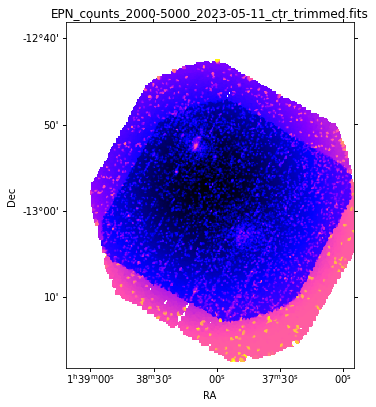

(714, 665)
-2.499111 -4.517144


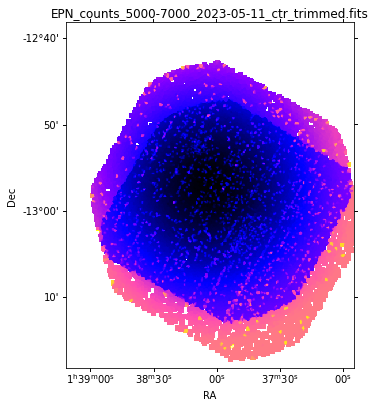

(714, 665)
-2.7542238 -4.533104


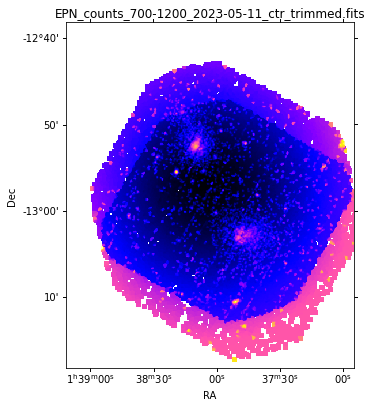

(714, 665)
-2.0578938 -4.5298443


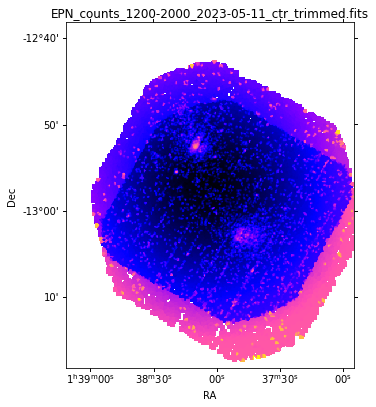

In [25]:

for file in glob(f'EPN*05-11*ctr_trimmed.fits'):
    title = file
    hdu = fits.open(f'{file}')[0]
    image_data = hdu.data
    print(image_data.shape)
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
    ra = ax.coords[0]
    dec = ax.coords[1]

    ra.set_axislabel('RA')
    dec.set_axislabel('Dec')
    image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
    astropy_conv = convolve(image_data, kernel)
    ax.set_title(title)
    print(np.nanmax(np.log10(image_data)), np.nanmin(np.log10(image_data)[image_data>0]))
    ax.matshow(np.log10(astropy_conv[50:650,50:550]), vmax = -3, cmap='gnuplot2',origin='lower')
    # plt.colorbar()
    plt.savefig(f'png/{os.path.basename(file).split(".")[0]}.png')
    plt.show()
    plt.close()


## STEP2: Scale PN exp map
Since PN effective area is different from MOS, thus to do sb profile PN exp map 

In [16]:
# from PIMMS
PN_scaling  = {'700-1200':[2.137, 7.92] , '700-2000':[2.024, 6.374] , 
'700-7000': [0.9817,2.916], '2000-7000': [0.5469, 1.474], '5000-7000': [2.547, 8.651], 
'2000-5000': [0.7015, 1.797], '1200-7000': [0.812, 2.181], '1200-2000': [1.937, 5.183]}

PN_scales = {}
for band in PN_scaling.keys():
    PN_scales[band] = PN_scaling[band][1]/PN_scaling[band][0]
print(PN_scales)

{'700-1200': 3.706130088909686, '700-2000': 3.149209486166008, '700-7000': 2.9703575430375877, '2000-7000': 2.695191076979338, '5000-7000': 3.3965449548488413, '2000-5000': 2.561653599429793, '1200-7000': 2.685960591133005, '1200-2000': 2.6757872999483734}


In [19]:
f = open('scale_PN_expmap.sh', 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
    f.write(f'fcarith EPN_exp_{band}_{today}.img.fits {PN_scales[band]} EPN_exp_{band}_{today}_scaled.fits "*"\n')
f.close()

## STEP3: merge btw inst

In [2]:
f = open(f'merge_inst_zhtools.sh', 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
    for type in ['counts', 'bkg']:
        f.write(f'addimages EMOS_{type}_{band}_{today}.fits EPN_{type}_{band}_{today}.fits EPIC_{type}_{band}_{today}.fits expand=no\n')
    f.write(f'addimages EMOS_exp_{band}_{today}.fits EPN_exp_{band}_{today}_scaled.fits EPIC_exp_{band}_{today}.fits expand=no\n')
f.close()

check the final vig-corrected, bkg-subtracted img

In [23]:
f = open(f'create_images.sh', 'w')

for ins in ['EPIC']:#,'xmm','chandra' # , 'EMOS','EPN'
    for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:#, 
        img = f'{ins}_counts_{band}_{today}.fits'
        exp = f'{ins}_exp_{band}_{today}.fits'
        bkg = f'{ins}_bkg_{band}_{today}.fits'
        f.write(f'farith {img} {bkg} {ins}_net_{band}_{today}.fits "-" clobber=yes\n')
        f.write(f'fimgtrim infile={ins}_net_{band}_{today}.fits threshlo=0 threshup=I const_lo=0 outfile={ins}_net_trimmed{band}_{today}.fits clobber=yes\n')
        f.write(f'farith {ins}_net_trimmed{band}_{today}.fits {exp} {ins}_net_ctr_{band}_{today}.fits "/" clobber=yes\n')
        f.write(f'fimgtrim infile={ins}_net_ctr_{band}_{today}.fits threshlo=0 threshup=I const_lo=0 outfile={ins}_net_ctr_trimmed_{band}_{today}.fits clobber=yes\n')
f.close()




(648, 648)
-2.0512088478998085 -4.857348588473643


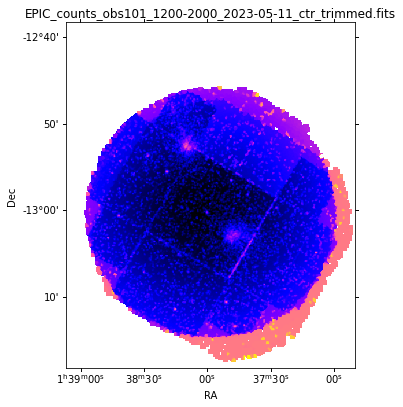

(648, 648)
-3.0046585142327533 -4.845585685205887


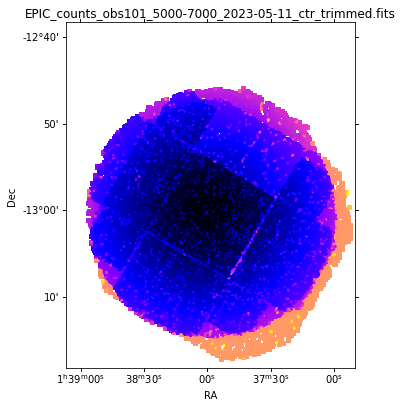

(648, 648)
-2.89079515849163 -4.854598667793682


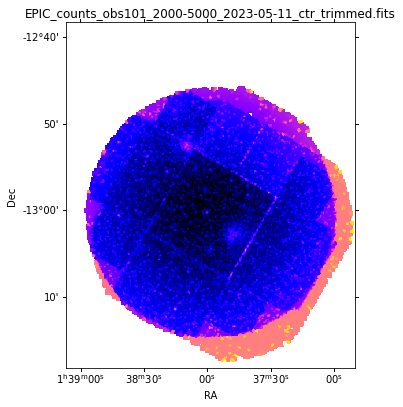

(648, 648)
-2.9296058374432072 -4.8559135076826685


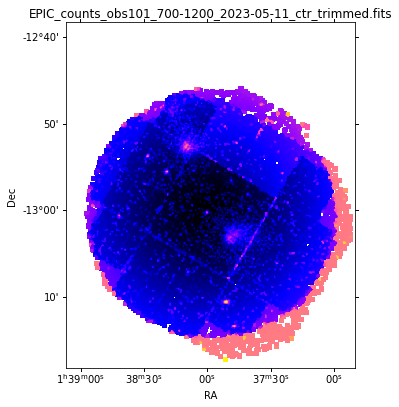

In [24]:
for file in glob(f'EPIC*05-11*ctr_trimmed.fits'):
    title = file
    hdu = fits.open(f'{file}')[0]
    image_data = hdu.data
    print(image_data.shape)
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
    ra = ax.coords[0]
    dec = ax.coords[1]

    ra.set_axislabel('RA')
    dec.set_axislabel('Dec')
    image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
    astropy_conv = convolve(image_data, kernel)
    ax.set_title(title)
    print(np.nanmax(np.log10(image_data)), np.nanmin(np.log10(image_data)[image_data>0]))
    ax.matshow(np.log10(astropy_conv[50:650,50:550]), vmax = -3, cmap='gnuplot2',origin='lower')
    # plt.colorbar()
    plt.savefig(f'png/{os.path.basename(file).split(".")[0]}.png')
    plt.show()
    plt.close()


## STEP*: use python to merge the instruments

1. merge emos epn

In [ ]:
date2 = '2023-05-05'
date1 = '2023-05-10'

for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
    datas = [f'EMOS1_counts_obs101_{band}_{date1}.img', f'EMOS2_counts_obs101_{band}_{date1}.img', f'EPN_counts_obs101_{band}_{date1}.img']
    exps = [f'EMOS1_exp_obs101_{band}_{date2}.img', f'EMOS2_exp_obs101_{band}_{date2}.img', f'EPN_exp_obs101_{band}.img']
    f = fits.open(datas[0])
    dat = np.zeros(f[0].data.shape)
    f = fits.open(exps[0])
    exp = np.zeros(f[0].data.shape)

    for i in range(3):
        f = fits.open(datas[i])
        dat += f[0].data
        f = fits.open(exps[i])
        exp += f[0].data

    os.system(f'cp {exps[0]} EPIC_exp_obs101_{band}_{today}.fits')
    os.system(f'cp {datas[0]} EPIC_counts_obs101_{band}_{today}.fits')

    
    ctr = dat/exp
    astropy_conv = convolve(ctr, kernel)

    plt.matshow(np.log10(astropy_conv[50:650,50:550]), vmax = 1, cmap='gnuplot2',origin='lower')
    plt.show()
    plt.close()

2. merge emos

# Don't Use Emosaic!! Since it uses reprojection, so it is unreliable. Use python and zhtool instead!

# 3. emosaic image and bkg images, and substract image with bkg 
remember to select bkg events for certain time slot for new energy bands in xmm_bkg_extraction.ipynb!


In [ ]:
import datetime
today = datetime.date.today
workdir = f'/stage/headat/yanling/xmm/reduction_230227/merged/{today}'
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
bkg_dir = f'/stage/headat/yanling/xmm/fwc_dat_2023-05-10'
for obs in [101, 201]:
        for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
                os.system(f'cp {bkg_dir}/imgs/EMOS1_obs{obs}_bkg_clean_{today}_{band}_scaled.img .')
                os.system(f'cp {bkg_dir}/imgs/EMOS2_obs{obs}_bkg_clean_{today}_{band}_scaled.img .')
                os.system(f'cp {bkg_dir}/imgs/EPN_obs{obs}_bkg_clean_{today}_{band}_scaled_corr.img .')

                # os.system(f'cp /stage/headat/yanling/xmm/reduction_230227/2023-05-10/EMOS1_counts_obs{obs}_{band}_2023-05-10.img .')
                # os.system(f'cp /stage/headat/yanling/xmm/reduction_230227/2023-05-10/EMOS2_counts_obs{obs}_{band}_2023-05-10.img .')
                # os.system(f'cp /stage/headat/yanling/xmm/reduction_230227/2023-05-10/EPN_corr_counts_obs{obs}_{band}_2023-05-10.img .')

                # os.system(f'cp /stage/headat/yanling/xmm/reduction_230227/2023-05-10/EMOS1_exp_obs{obs}_{band}_2023-05-10.img .')
                # os.system(f'cp /stage/headat/yanling/xmm/reduction_230227/2023-05-10/EMOS2_exp_obs{obs}_{band}_2023-05-10.img .')
                # os.system(f'cp /stage/headat/yanling/xmm/reduction_230227/2023-05-10/EPN_corr__obs{obs}_{band}_2023-05-10.img .')


merge btw instruments

In [ ]:
date2 = '2023-05-05'
date1 = '2023-05-10'
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged/2023-05-11'
os.chdir(workdir)
f = open(f'img_merge_instruments_{today}.sh' , 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
    datas = f'EMOS1_counts_obs101_{band}_{date1}.img EMOS2_counts_obs101_{band}_{date1}.img EPN_counts_obs101_{band}_{date1}.img'
    exps = f'EMOS1_exp_obs101_{band}_{date2}.img EMOS2_exp_obs101_{band}_{date2}.img EPN_exp_obs101_{band}.img'
    # bkgs = f'EMOS1_obs101_bkg_{band}_{today}.img EMOS2_obs101_bkg_{band}_{today}.img EPN_obs101_bkg_{band}_{today}.img'

    # print(f'emosaic imagesets="{datas}" mosaicedset=EPIC_counts_obs101_{band}_{today}.img withexposure=no')
    # print(f'emosaic imagesets="{exps}" mosaicedset=EPIC_exp_obs101_{band}_{today}.img withexposure=no')
    # print(f'emosaic imagesets="{bkgs}" mosaicedset=EPIC_obs101_bkg_{band}_{today}.img withexposure=no')
    f.write(f'emosaic imagesets="{datas}" mosaicedset=EPIC_counts_obs101_{band}_{today}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{exps}" mosaicedset=EPIC_exp_obs101_{band}_{today}.img withexposure=no\n')
    # f.write(f'emosaic imagesets="{bkgs}" mosaicedset=EPIC_obs101_bkg_{band}_{today}.img withexposure=no\n')
f.close()

stack 1 obs using python

In [ ]:
date2 = '2023-05-05'
date1 = '2023-05-10'

for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
    datas = [f'EMOS1_counts_obs101_{band}_{date1}.img', f'EMOS2_counts_obs101_{band}_{date1}.img', f'EPN_counts_obs101_{band}_{date1}.img']
    exps = [f'EMOS1_exp_obs101_{band}_{date2}.img', f'EMOS2_exp_obs101_{band}_{date2}.img', f'EPN_exp_obs101_{band}.img']
    f = fits.open(datas[0])
    dat = np.zeros(f[0].data.shape)
    f = fits.open(exps[0])
    exp = np.zeros(f[0].data.shape)

    for i in range(3):
        f = fits.open(datas[i])
        dat += f[0].data
        f = fits.open(exps[i])
        exp += f[0].data

    ctr = dat/exp
    astropy_conv = convolve(ctr, kernel)

    plt.matshow(np.log10(astropy_conv[50:650,50:550]), vmax = 1, cmap='gnuplot2',origin='lower')
    plt.show()
    plt.close()

make ctr images

In [ ]:

f = open(f'create_images.sh', 'w')

for ins in ['EPIC']:#,'xmm','chandra' # , 'EMOS','EPN'
        for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:#, 

            img = f'{ins}_counts_obs101_{band}_{today}.img'
            # exp = f'{ins}_exp_{band}_{today}_edgemsk_srcmsk_{clus}_filamsk_bigeschipgapmasked.fits'
            # exp = f'{ins}_exp_{band}_{today}_edgemsk_srcmsk_{clus}_filamsk.fits'
            exp = f'{ins}_exp_obs101_{band}_{today}.img'
            # bkg = glob(f'{ins}_bkg_{band}_{today}.img')[0]
            # f.write(f'farith {img} {bkg} {img.split(".")[0]}_net.fits "-" clobber=yes\n')
            # f.write(f'fimgtrim infile={img.split(".")[0]}_net.fits threshlo=0 threshup=I const_lo=0 outfile={img.split(".")[0]}_net_trimmed.fits clobber=yes\n')
            f.write(f'farith {img.split(".")[0]}.img {exp} {img.split(".")[0]}_ctr.fits "/" clobber=yes\n')
            f.write(f'fimgtrim infile={img.split(".")[0]}_ctr.fits threshlo=0 threshup=I const_lo=0 outfile={img.split(".")[0]}_ctr_trimmed.fits clobber=yes\n')
f.close()




check images

In [ ]:
os.makedirs('png', exist_ok=True)

for file in glob(f'*obs101*ctr_trimmed.fits'):
    title = file
    hdu = fits.open(f'{file}')[0]
    image_data = hdu.data
    print(image_data.shape)
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
    ra = ax.coords[0]
    dec = ax.coords[1]

    ra.set_axislabel('RA')
    dec.set_axislabel('Dec')
    image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
    astropy_conv = convolve(image_data, kernel)
    ax.set_title(title)
    print(np.nanmax(np.log10(image_data)), np.nanmin(np.log10(image_data)[image_data>0]))
    ax.matshow(np.log10(astropy_conv[50:650,50:550]), vmax = -3, cmap='gnuplot2',origin='lower')
    # plt.colorbar()
    plt.savefig(f'png/{os.path.basename(file).split(".")[0]}.png')
    plt.show()
    plt.close()


merge btw obs

In [ ]:
date = '2023-05-10'
today = '2023-05-11'
workpath = '/stage/headat/yanling/xmm/reduction_230227/merged/2023-05-11'
f = open(f'{workpath}/img_merge_obs_bands_{today}.sh' , 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000',]:    
    datas = f'EMOS1_counts_obs101_{band}_{date}.img EMOS1_counts_obs201_{band}_{date}.img'
    exps = f'EMOS1_exp_obs101_{band}_{date}.img EMOS1_exp_obs201_{band}_{date}.img'
    bkgs = f'EMOS1_obs101_bkg_clean_{today}_{band}_scaled.img EMOS1_obs201_bkg_clean_{today}_{band}_scaled.img'
    # print(f'emosaic imagesets="{datas}" mosaicedset=EMOS1_cts_{band}_{today}.img withexposure=no')
    # print(f'emosaic imagesets="{exps}" mosaicedset=EMOS1_exp_{band}_{today}.img withexposure=no')
    # print(f'emosaic imagesets="{bkgs}" mosaicedset=EMOS1_bkg_{band}_{today}.img withexposure=no')
    # f.write(f'emosaic imagesets="{datas}" mosaicedset=EMOS1_cts_{band}_{today}.img withexposure=no\n')
    # f.write(f'emosaic imagesets="{exps}" mosaicedset=EMOS1_exp_{band}_{today}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{bkgs}" mosaicedset=EMOS1_bkg_{band}_{today}.img withexposure=no\n')

    datas = f'EMOS2_counts_obs101_{band}_{date}.img EMOS2_counts_obs201_{band}_{date}.img'
    exps = f'EMOS2_exp_obs101_{band}_{date}.img EMOS2_exp_obs201_{band}_{date}.img'
    bkgs = f'EMOS2_obs101_bkg_clean_{today}_{band}_scaled.img EMOS2_obs201_bkg_clean_{today}_{band}_scaled.img'
    # print(f'emosaic imagesets="{datas}" mosaicedset=EMOS2_cts_{band}_{today}.img withexposure=no')
    # print(f'emosaic imagesets="{exps}" mosaicedset=EMOS2_exp_{band}_{today}.img withexposure=no')
    # print(f'emosaic imagesets="{bkgs}" mosaicedset=EMOS2_bkg_{band}_{today}.img withexposure=no')
    # f.write(f'emosaic imagesets="{datas}" mosaicedset=EMOS2_cts_{band}_{today}.img withexposure=no\n')
    # f.write(f'emosaic imagesets="{exps}" mosaicedset=EMOS2_exp_{band}_{today}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{bkgs}" mosaicedset=EMOS2_bkg_{band}_{today}.img withexposure=no\n')

    datas = f'EPN_counts_obs101_{band}_{date}.img EPN_counts_obs201_{band}_{date}.img'
    exps = f'EPN_exp_obs101_{band}.img EPN_exp_obs201_{band}.img'
    bkgs = f'EPN_obs101_bkg_clean_{today}_{band}_scaled_corr.img EPN_obs201_bkg_clean_{today}_{band}_scaled_corr.img'
    # print(f'emosaic imagesets="{datas}" mosaicedset=EPN_cts_{band}_{today}.img withexposure=no')
    # print(f'emosaic imagesets="{exps}" mosaicedset=EPN_exp_{band}_{today}.img withexposure=no')
    # print(f'emosaic imagesets="{bkgs}" mosaicedset=EPN_bkg_{band}_{today}.img withexposure=no')
    # f.write(f'emosaic imagesets="{datas}" mosaicedset=EPN_cts_{band}_{today}.img withexposure=no\n')
    # f.write(f'emosaic imagesets="{exps}" mosaicedset=EPN_exp_{band}_{today}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{bkgs}" mosaicedset=EPN_bkg_{band}_{today}.img withexposure=no\n')
f.close()

emosaic all images

In [ ]:
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged/2023-05-11'
os.chdir(workdir)
f = open(f'img_merge_all_bands_{today}.sh' , 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000',]:
    datas = f'EMOS1_cts_{band}_{today}.img EMOS2_cts_{band}_{today}.img EPN_cts_{band}_{today}.img'
    exps = f'EMOS1_exp_{band}_{today}.img EMOS2_exp_{band}_{today}.img EPN_exp_{band}_{today}.img'
    bkgs = f'EMOS1_bkg_{band}_{today}.img EMOS2_bkg_{band}_{today}.img EPN_bkg_{band}_{today}.img'

    # print(f'emosaic imagesets="{datas}" mosaicedset=EPIC_cts_{band}_{today}.img withexposure=no')
    # print(f'emosaic imagesets="{exps}" mosaicedset=EPIC_exp_{band}_{today}.img withexposure=no')
    # print(f'emosaic imagesets="{bkgs}" mosaicedset=EPIC_bkg_{band}_{today}.img withexposure=no')
    # f.write(f'emosaic imagesets="{datas}" mosaicedset=EPIC_cts_{band}_{today}.img withexposure=no\n')
    # f.write(f'emosaic imagesets="{exps}" mosaicedset=EPIC_exp_{band}_{today}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{bkgs}" mosaicedset=EPIC_bkg_{band}_{today}.img withexposure=no\n')
f.close()

subtract bkg

In [ ]:
# data-bkg
instruments = ['EMOS1', 'EMOS2', 'EPN']
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged'
os.chdir(workdir)
f = open('data_sub_bkg.sh', 'w')
for ins in instruments:
    for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000',]:
        blo = band.split('-')[0]
        bhi = band.split('-')[1]
        f.write(f'farith {ins}_cts_{blo}-{bhi}.img {ins}_bkg_{blo}-{bhi}.img {ins}_net_{blo}-{bhi}.img "-" clobber=yes\n')
        # f.write(f'farith {ins}_net_{blo}-{bhi}.img {ins}_exp_{blo}-{bhi}.img {ins}_net_ctr_{blo}-{bhi}.img "/" clobber=yes\n')
f.close()

only merge mos1, mos2

In [ ]:
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged/2023-05-11'
os.chdir(workdir)
f = open(f'img_merge_mos_all_bands_{today}.sh' , 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
    blo = band.split('-')[0]
    bhi = band.split('-')[1]
    
    datas = f'EMOS1_cts_{band}_{today}.img EMOS2_cts_{band}_{today}.img'
    exps = f'EMOS1_exp_{band}_{today}.img EMOS2_exp_{band}_{today}.img'
    bkgs = f'EMOS1_bkg_{band}_{today}.img EMOS2_bkg_{band}_{today}.img'

    # print(f'emosaic imagesets="{datas}" mosaicedset=EMOS_cts_{band}_{today}.img withexposure=no')
    # print(f'emosaic imagesets="{exps}" mosaicedset=EMOS_exp_{band}_{today}.img withexposure=no')
    # print(f'emosaic imagesets="{bkgs}" mosaicedset=EMOS_bkg_{band}_{today}.img withexposure=no')
    # f.write(f'emosaic imagesets="{datas}" mosaicedset=EMOS_cts_{band}_{today}.img withexposure=no\n')
    # f.write(f'emosaic imagesets="{exps}" mosaicedset=EMOS_exp_{band}_{today}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{bkgs}" mosaicedset=EMOS_bkg_{band}_{today}.img withexposure=no\n')
f.close()

merge all energy bands to get 0.7-7 keV, 2-7keV, 1.2-7, 0.7-2 keV band (only for mos)

In [ ]:
f = open(f'img_merge_mos_combine_bands_{today}.sh' , 'w')
for type in ['bkg']: #'exp', 'cts', 
    f.write(f'farith EMOS_{type}_700-1200_{today}.img EMOS_{type}_1200-2000_{today}.img EMOS_{type}_700-2000_{today}.img "+" clobber=yes\n')
    f.write(f'farith EMOS_{type}_2000-5000_{today}.img EMOS_{type}_5000-7000_{today}.img EMOS_{type}_2000-7000_{today}.img "+" clobber=yes\n')
    f.write(f'farith EMOS_{type}_700-2000_{today}.img EMOS_{type}_2000-7000_{today}.img EMOS_{type}_700-7000_{today}.img "+" clobber=yes\n')
    f.write(f'farith EMOS_{type}_1200-2000_{today}.img EMOS_{type}_2000-7000_{today}.img EMOS_{type}_1200-7000_{today}.img "+" clobber=yes\n')

f.close()

merge all energy bands to get 0.7-7 keV, 2-7keV, 1.2-7, 0.7-2 keV band (only for pn)


In [ ]:

f = open(f'img_merge_PN_combine_bands_{today}.sh' , 'w')
for type in ['cts', 'exp', 'bkg']:
    f.write(f'farith EPN_{type}_700-1200_{today}.img EPN_{type}_1200-2000_{today}.img EPN_{type}_700-2000_{today}.img "+"\n')
    f.write(f'farith EPN_{type}_2000-5000_{today}.img EPN_{type}_5000-7000_{today}.img EPN_{type}_2000-7000_{today}.img "+"\n')
    f.write(f'farith EPN_{type}_700-2000_{today}.img EPN_{type}_2000-7000_{today}.img EPN_{type}_700-7000_{today}.img "+"\n')
    f.write(f'farith EPN_{type}_1200-2000_{today}.img EPN_{type}_2000-7000_{today}.img EPN_{type}_1200-7000_{today}.img "+"\n')

f.close()

merge all energy bands (for mos and pn)

In [ ]:

f = open(f'img_merge_combine_bands_{today}.sh' , 'w')
for type in ['bkg']:#'cts', 'exp', 
    f.write(f'farith EMOS_{type}_700-2000_{today}.img EPN_{type}_700-2000_{today}.img EPIC_{type}_700-2000_{today}.img "+" clobber=yes \n')
    f.write(f'farith EMOS_{type}_2000-7000_{today}.img EPN_{type}_2000-7000_{today}.img EPIC_{type}_2000-7000_{today}.img "+" clobber=yes \n')
    f.write(f'farith EMOS_{type}_700-7000_{today}.img EPN_{type}_700-7000_{today}.img EPIC_{type}_700-7000_{today}.img "+" clobber=yes \n')
    f.write(f'farith EMOS_{type}_1200-7000_{today}.img EPN_{type}_1200-7000_{today}.img EPIC_{type}_1200-7000_{today}.img "+" clobber=yes \n')

f.close()

merge masked exposure maps

In [ ]:
workpath = '/stage/headat/yanling/xmm/reduction_230227/merged/2023-05-07/emosaic_masked_expmap'
os.chdir(workpath)
today = '2023-05-07'
f = open(f'{workpath}/merge_mos_mask_expmaps_{today}.sh' , 'w')
bands = ['700-1200', '1200-2000', '2000-5000', '5000-7000']
merged_bands = ['700-2000', '2000-7000']
types = ['edgemsk_srcmsk_A222_filamsk', 'edgemsk_srcmsk_A223_filamsk', 'edgemsk_srcmsk', 'edgemsk']
# only EMOS, separate bands
for band in bands:
    for type in types:
        for obs in ['101', '201']:
            exps = f'EMOS1_exp_obs{obs}_{band}_2023-05-05_{today}_{type}.fits EMOS2_exp_obs{obs}_{band}_2023-05-05_{today}_{type}.fits'
            f.write(f'emosaic imagesets="{exps}" mosaicedset=EMOS_exp_obs{obs}_{band}_{today}_{type}.fits withexposure=no\n')
        f.write(f'emosaic imagesets="EMOS_exp_obs101_{band}_{today}_{type}.fits EMOS_exp_obs201_{band}_{today}_{type}.fits" mosaicedset=EMOS_exp_{band}_{today}_{type}.fits withexposure=no\n')
f.close()

# only EPN, separate bands
f = open(f'{workpath}/merge_pn_mask_expmaps_{today}.sh' , 'w')
for band in bands:
    for type in types:
        exps = f'EPN_exp_obs101_{band}_{today}_{type}.fits EPN_exp_obs201_{band}_{today}_{type}.fits'
        f.write(f'emosaic imagesets="{exps}" mosaicedset=EPN_exp_{band}_{today}_{type}.fits withexposure=no\n')
f.close()

# EPIC = EPN + EMOS, separate bands
f = open(f'{workpath}/merge_epic_mask_expmaps_{today}.sh' , 'w')
for band in bands:
    for type in types:
        exps = f'EPN_exp_{band}_{today}_{type}.fits EMOS_exp_{band}_{today}_{type}.fits'
        f.write(f'emosaic imagesets="{exps}" mosaicedset=EPIC_exp_{band}_{today}_{type}.fits withexposure=no\n')
f.close()

# EPIC, EPN, EMOS, merged bands using farith
f = open(f'{workpath}/merge_bands_expmaps_epic_epn_emos_{today}.sh' , 'w')
for inst in ['EMOS', 'EPN', 'EPIC']:
    for type in types:
        f.write(f'farith {inst}_exp_700-1200_{today}_{type}.fits {inst}_exp_1200-2000_{today}_{type}.fits {inst}_exp_700-2000_{today}_{type}.fits "+"\n')
        f.write(f'farith {inst}_exp_2000-5000_{today}_{type}.fits {inst}_exp_5000-7000_{today}_{type}.fits {inst}_exp_2000-7000_{today}_{type}.fits "+"\n')
        f.write(f'farith {inst}_exp_700-2000_{today}_{type}.fits {inst}_exp_2000-7000_{today}_{type}.fits {inst}_exp_700-7000_{today}_{type}.fits "+"\n')
        f.write(f'farith {inst}_exp_1200-2000_{today}_{type}.fits {inst}_exp_2000-7000_{today}_{type}.fits {inst}_exp_1200-7000_{today}_{type}.fits "+"\n')
f.close()

make vignetted, bkg-subtracted images

In [ ]:
date1 = '2023-05-10'
date2 = '2023-05-07'
f = open(f'create_images.sh', 'w')

for ins in ['EPIC', 'EMOS','EPN']:#,'xmm','chandra'
        for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000', '700-7000', "700-2000", "2000-7000", "1200-7000"]:#, 
            for clus in ['A222', 'A223']:

                img = f'{ins}_cts_{band}_{date1}.img'
                # exp = f'{ins}_exp_{band}_{today}_edgemsk_srcmsk_{clus}_filamsk_bigeschipgapmasked.fits'
                # exp = f'{ins}_exp_{band}_{today}_edgemsk_srcmsk_{clus}_filamsk.fits'
                exp = f'{ins}_exp_{band}_{date2}_edgemsk_srcmsk.fits'
                bkg = glob(f'{ins}_bkg_{band}_{today}.img')[0]
                f.write(f'farith {img} {bkg} {img.split(".")[0]}_net.fits "-" clobber=yes\n')
                f.write(f'fimgtrim infile={img.split(".")[0]}_net.fits threshlo=0 threshup=I const_lo=0 outfile={img.split(".")[0]}_net_trimmed.fits clobber=yes\n')
                f.write(f'farith {img.split(".")[0]}_net_trimmed.fits {exp} {img.split(".")[0]}_net_ctr.fits "/" clobber=yes\n')
                f.write(f'fimgtrim infile={img.split(".")[0]}_net_ctr.fits threshlo=0 threshup=I const_lo=0 outfile={img.split(".")[0]}_net_ctr_trimmed.fits clobber=yes\n')
f.close()




for unmosaic images ctr maps

In [ ]:
date1 = '2023-05-10'
date2 = '2023-05-07'
f = open(f'create_images.sh', 'w')

for ins in ['EPIC', 'EMOS', 'EPN']:#,'xmm','chandra'
    for obs in [101,201]:
        for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000', '700-7000', "700-2000", "2000-7000", "1200-7000"]:#, 
            for clus in ['A222', 'A223']:
                img = f'{ins}_counts_{band}_{date1}.img'
                # exp = f'{ins}_exp_{band}_{today}_edgemsk_srcmsk_{clus}_filamsk_bigeschipgapmasked.fits'
                # exp = f'{ins}_exp_{band}_{today}_edgemsk_srcmsk_{clus}_filamsk.fits'
                exp = f'{ins}_exp_{band}_{date2}_edgemsk_srcmsk.fits'
                bkg = glob(f'{ins}_bkg_{band}_{today}.img')[0]
                f.write(f'farith {img} {bkg} {img.split(".")[0]}_net.fits "-" clobber=yes\n')
                f.write(f'fimgtrim infile={img.split(".")[0]}_net.fits threshlo=0 threshup=I const_lo=0 outfile={img.split(".")[0]}_net_trimmed.fits clobber=yes\n')
                f.write(f'farith {img.split(".")[0]}_net_trimmed.fits {exp} {img.split(".")[0]}_net_ctr.fits "/" clobber=yes\n')
                f.write(f'fimgtrim infile={img.split(".")[0]}_net_ctr.fits threshlo=0 threshup=I const_lo=0 outfile={img.split(".")[0]}_net_ctr_trimmed.fits clobber=yes\n')
f.close()




check the final images

In [ ]:
os.makedirs('png', exist_ok=True)

for file in glob(f'*cts*.img'):
    title = file
    hdu = fits.open(f'{file}')[0]
    image_data = hdu.data
    print(image_data.shape)
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
    ra = ax.coords[0]
    dec = ax.coords[1]

    ra.set_axislabel('RA')
    dec.set_axislabel('Dec')
    image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
    astropy_conv = convolve(image_data, kernel)
    ax.set_title(title)
    print(np.nanmax(np.log10(image_data)), np.nanmin(np.log10(image_data)[image_data>0]))
    ax.matshow(np.log10(astropy_conv[50:650,50:550]), vmax = -2, cmap='gnuplot2',origin='lower')
    # plt.colorbar()
    plt.savefig(f'png/{os.path.basename(file).split(".")[0]}.png')
    plt.show()
    plt.close()


# 5. wavdetect xmm

create fov image

In [ ]:
f = open('gen_fov.sh', 'w')
instruments = ['EPIC']
for ins in instruments:
    print(f'dmimgcalc {ins}_net.img none {ins}_psf.fits op="imgout=((img1*0)+9.0)" clobber=yes')
    f.write(f'dmimgcalc {ins}_net.img none {ins}_psf.fits op="imgout=((img1*0)+9.0)" clobber=yes\n')
    print(f'dmhedit {ins}_psf.fits none add BUNIT "arcsec"')
    f.write(f'dmhedit {ins}_psf.fits none add BUNIT "arcsec"\n')

f.close()


perform wavdetect

In [ ]:
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged'
instruments = ['EPIC']
sigthresh = 2e-6

os.makedirs(f'{workdir}/wavdetect_sig{sigthresh}', exist_ok = True)
os.chdir(f'{workdir}/wavdetect_sig{sigthresh}')
f = open(f'wavdetect.sh', 'w')
for ins in instruments:
    print(f'punlearn wavdetect')
    f.write(f'punlearn wavdetect')
    print(f'wavdetect infile=../{ins}_net.img outfile={ins}_src.fits scellfile={ins}_scell.fits imagefile={ins}_imgfile.fits expfile=../{ins}_exp.img defnbkgfile={ins}_nbgd.fits regfile={ins}_src.reg scales="1.0 2.0 4.0" clobber=yes ellsigma=4 sigthresh={sigthresh} psffile=../{ins}_psf.fits ')
    f.write(f'wavdetect infile=../{ins}_net.img outfile={ins}_src.fits scellfile={ins}_scell.fits imagefile={ins}_imgfile.fits expfile=../{ins}_exp.img defnbkgfile={ins}_nbgd.fits regfile={ins}_src.reg scales="1.0 2.0 4.0" clobber=yes ellsigma=4 sigthresh={sigthresh} psffile=../{ins}_psf.fits ')
f.close()

perform emldetect

In [ ]:
likelihood=6

run srcflux

1. define bkg regions 

In [ ]:
#streak region is a random circle region out of fov
os.chdir('/stage/headat/yanling/xmm/reduction_230227/merged/wavdetect')
instruments = ['EPN', 'EMOS1', 'EMOS2']
for ins in instruments:
    os.makedirs(f'./rui_src', exist_ok=True)
    print(f'roi infile=srclist_sum_ex_extend_byeye.fits outsrc="rui_src/src%d.fits" radiusmode=mul bkgradius=2 group=individual fovregion="region({ins}_fov.reg)" streakregion="circle(572,650,34)"')

combine regions from fits files in reg file and check

In [ ]:
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged/wavdetect'
for ins in instruments:
    f1 = open(f'{workdir}/{ins}_allsrc_individual.reg', 'w')
    f2 = open(f'{workdir}/{ins}_allbkg_individual.reg', 'w')
    f1.write('physical\n')
    f2.write('physical\n')
    reglists = glob.glob(f'{workdir}/{ins}_src_regions_individual/src*.fits')
    for reg in reglists:
        hdul = fits.open(reg)
        l = hdul['SRCREG'].data
        for i in range(len(l['X'])):
            f1.write(f"ellipse({l['X'][i]},{l['Y'][i]},{l['R'][i][0]},{l['R'][i][1]},{l['ROTANG'][i][0]})\n")
        l = hdul['BKGREG'].data
        i = 0
        f2.write(f"ellipse({l['X'][i]},{l['Y'][i]},{l['R'][i][0]},{l['R'][i][1]},{l['ROTANG'][i][0]})\n")
        for i in range(1,len(l['X'])):
            f2.write(f"-ellipse({l['X'][i]},{l['Y'][i]},{l['R'][i][0]},{l['R'][i][1]},{l['ROTANG'][i][0]})\n")
    f1.close()
    f2.close()

In [ ]:
# 在 vim 中删掉有nan 的行
# 删掉两个 cluster
# -> edited.reg

In [ ]:
for ins in instruments:
    f1 = open(f'{ins}_src.lis', 'w')
    f2 = open(f'{ins}_bkg.lis', 'w')
    reglists = glob.glob(f'{workdir}/{ins}_src_regions_individual/src*.fits')
    for i in range(len(reglists)):
        f1.write(f'{ins}_src_regions_individual/src{i+1}.fits["SRCREG"]\n')
        f2.write(f'{ins}_src_regions_individual/src{i+1}.fits["BKGREG"]\n')
    f1.close()
    f2.close()

run srcflux !srcflux can't run XMM dataset!

In [ ]:

for ins in instruments:
    os.makedirs(f'{workdir}/{ins}_srcflux', exist_ok=True)
    print('punlearn srcflux')
    print(f'srcflux infile=../../../101/{ins}_clean.fits pos=../../{ins}_src.fits outroot=srcflux bands=2.0:8.0:3.8 srcreg=@../{ins}_src.lis bkgreg=@../{ins}_bkg.lis psfmethod=ideal model="xstbabs.abs1*xspowerlaw.pow1" paramvals="pow1.PhoIndex=1.4" absmodel="xstbabs.abs1" absparams="abs1.nH=1.62e-20" abund=lodd clobber=yes')

use wavdetect to briefly estimate detection limit of point sources

In [ ]:
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged'
hdul = fits.open(f'{workdir}/wavdetect_sig1e-06/EPIC_src.fits')
# path = '/stage/headat/yanling/chandra/chandra/data/wavdetect_232223'
# hdul = fits.open(f'{path}/wavdetect_merge_clean_withexp_src.fits')
dat = hdul[1].data
plt.hist(dat['NET_RATE'], np.logspace(-4,-1,20))
plt.xscale('log')
plt.yscale('log')
plt.axvline(5E-4, color='r')
plt.show()
print(len(dat['NET_RATE']), dat['NET_RATE'].max())
print(np.arange(len(dat['NET_RATE']))[dat['NET_RATE']> 0.8e-6])
print(len(np.arange(len(dat['NET_RATE']))[dat['NET_RATE']> 0.8e-6]))

exclude the src reg list via histogram above

In [ ]:
path = '/stage/headat/yanling/xmm/reduction_230227/merged/wavdetect_sig1e-06'
newf = open(f'{path}/EPIC_src_ctr5e-3.reg', 'w')
f = open(f'{path}/EPIC_src.reg')
hdul = fits.open(f'{path}/EPIC_src.fits')
dat = hdul[1].data
lines = f.readlines()
f.close()
lines = np.array(lines)[dat['NET_RATE']>5e-3]
for line in lines:
    newf.write(line)
newf.close()

create suzaku point source regions based on this (run locally)

In [ ]:
path = '.'
f = open(f'{path}/EPIC_src_ctr1e-3_fk5.reg')
newf = open(f'{path}/EPIC_src_ctr1e-3_fk5_suzaku_9am.reg','w')
lines = f.readlines()[3:]
f.close()
newf.write('fk5\n')
for line in lines:
    ra = line.split('(')[-1].split(',')[0]
    dec = line.split('(')[-1].split(',')[1]
    newf.write(f"circle({ra},{dec},0.9')\n")
newf.close()